# P04-Telecom: 通讯公司客户响应速度提升

## 项目概述

本项目通过RFM分析和机器学习方法,帮助通讯运营商:
1. 识别高价值客户(冠军客户、忠诚客户)
2. 预测客户流失风险
3. 制定针对性的营销策略

## 学习目标

- 掌握RFM分析方法及其在客户价值评估中的应用
- 理解客户细分的业务意义
- 使用随机森林进行分类任务(流失预测)
- 处理类别不平衡问题
- 解释模型结果并提出业务建议

## 1. 环境准备与数据加载

In [1]:
# 导入必需库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path

# 设置中文字体和绘图样式
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set_palette("Set2")

# 设置随机种子确保可复现
np.random.seed(42)

print("环境准备完成!")

环境准备完成!


In [2]:
# 加载数据
data_path = "../../../../data/stage3/telecom_customer_data.csv"

# 注意: 这里使用相对路径,实际数据路径可能需要调整
# 如果数据不存在,请先运行: python scripts/data/download-stage3.py --project p04-telecom

try:
    df = pd.read_csv(data_path)
    print(f"成功加载数据: {len(df)}行, {len(df.columns)}列")
    print(f"\n数据前5行:")
    display(df.head())
except FileNotFoundError:
    print(f"错误: 数据文件不存在 ({data_path})")
    print("请先运行数据下载脚本: python scripts/data/download-stage3.py --project p04-telecom")

成功加载数据: 100000行, 13列

数据前5行:


,customer_id,registration_date,last_transaction_date,transaction_count,total_amount,avg_amount_per_transaction,service_type,contract_type,complaint_count,service_call_count,churn,age_group,region
0,C000001,2023-04-25,2024-11-07,31,3017.13,97.33,移动套餐,月付,0,0,0,26-35,华中
1,C000002,2023-08-27,2024-12-31,31,3506.44,113.11,宽带,月付,1,1,0,26-35,华南
2,C000003,2023-08-09,2024-11-03,22,1957.90,89.00,全业务,月付,0,4,0,18-25,华东
3,C000004,2024-01-06,2024-12-19,33,3415.46,103.50,宽带,年付,0,2,0,18-25,华东
4,C000005,2023-12-30,2024-12-11,34,3883.43,114.22,移动套餐,月付,0,3,0,56+,华南


In [3]:
# 数据基本信息
print("数据信息:")
print(df.info())

print("\n数值型特征统计:")
display(df.describe())

数据信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   customer_id                 100000 non-null  object 
 1   registration_date           100000 non-null  object 
 2   last_transaction_date       100000 non-null  object 
 3   transaction_count           100000 non-null  int64  
 4   total_amount                100000 non-null  float64
 5   avg_amount_per_transaction  100000 non-null  float64
 6   service_type                100000 non-null  object 
 7   contract_type               100000 non-null  object 
 8   complaint_count             100000 non-null  int64  
 9   service_call_count          100000 non-null  int64  
 10  churn                       100000 non-null  int64  
 11  age_group                   100000 non-null  object 
 12  region                      100000 non-null  object 
dtypes: float6

,transaction_count,total_amount,avg_amount_per_transaction,complaint_count,service_call_count,churn
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,29.485640,2949.319656,100.031603,0.729890,2.311550,0.150810
std,5.462178,622.807598,10.006513,1.015865,1.678635,0.357865
min,5.000000,468.440000,51.880000,0.000000,0.000000,0.000000
25%,26.000000,2519.360000,93.337500,0.000000,1.000000,0.000000
50%,29.000000,2925.585000,99.990000,0.000000,2.000000,0.000000
75%,33.000000,3354.242500,106.770000,1.000000,3.000000,0.000000
max,55.000000,6189.630000,149.270000,10.000000,13.000000,1.000000


In [4]:
# 检查缺失值
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if len(missing) > 0:
    print("存在缺失值的列:")
    print(missing)
    print(f"\n缺失值占比: {missing / len(df) * 100}%")
else:
    print("数据无缺失值!")

数据无缺失值!


流失情况统计:
  未流失客户: 84919人 (84.9%)
  已流失客户: 15081人 (15.1%)
  流失率: 15.08%


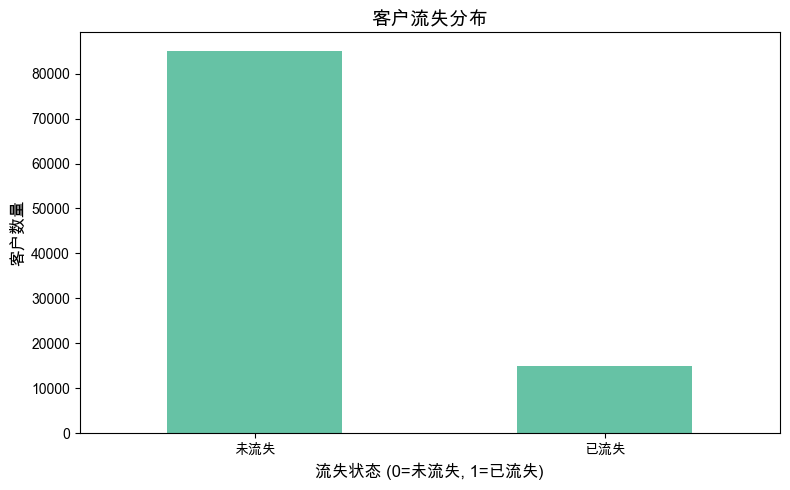

In [5]:
# 目标变量分布(流失率)
churn_counts = df['churn'].value_counts()
churn_rate = df['churn'].mean()

print(f"流失情况统计:")
print(f"  未流失客户: {churn_counts[0]}人 ({(1-churn_rate)*100:.1f}%)")
print(f"  已流失客户: {churn_counts[1]}人 ({churn_rate*100:.1f}%)")
print(f"  流失率: {churn_rate:.2%}")

# 可视化
fig, ax = plt.subplots(figsize=(8, 5))
churn_counts.plot(kind='bar', ax=ax)
ax.set_title('客户流失分布', fontsize=14)
ax.set_xlabel('流失状态 (0=未流失, 1=已流失)', fontsize=12)
ax.set_ylabel('客户数量', fontsize=12)
ax.set_xticklabels(['未流失', '已流失'], rotation=0)
plt.tight_layout()
plt.show()

## 2. RFM分析

### 2.1 什么是RFM?

RFM是客户价值评估的经典模型,包含三个维度:
- **R (Recency)**: 最近一次消费距今天数,越小越好(最近消费=活跃)
- **F (Frequency)**: 消费频率(交易次数),越多越好(高频=忠诚)
- **M (Monetary)**: 消费金额,越高越好(高消费=价值高)

每个维度按五分位数划分为1-5分(5分最好),总分0-15分。

In [6]:
# 数据预处理: 转换日期格式
df['registration_date'] = pd.to_datetime(df['registration_date'])
df['last_transaction_date'] = pd.to_datetime(df['last_transaction_date'])

# 设置分析基准日期(通常为数据最新日期)
analysis_date = pd.to_datetime('2024-12-31')
print(f"分析基准日期: {analysis_date}")

分析基准日期: 2024-12-31 00:00:00


In [7]:
# 计算RFM指标

# R: 最近消费距今天数
df['recency'] = (analysis_date - df['last_transaction_date']).dt.days

# F: 消费频率(交易次数)
df['frequency'] = df['transaction_count']

# M: 消费金额
df['monetary'] = df['total_amount']

print("RFM原始指标统计:")
print(df[['recency', 'frequency', 'monetary']].describe())

RFM原始指标统计:
            recency      frequency       monetary
count  100000.00000  100000.000000  100000.000000
mean       71.21063      29.485640    2949.319656
std        73.07737       5.462178     622.807598
min         0.00000       5.000000     468.440000
25%        26.00000      26.000000    2519.360000
50%        53.00000      29.000000    2925.585000
75%        80.00000      33.000000    3354.242500
max       365.00000      55.000000    6189.630000


In [8]:
# 计算RFM评分(1-5分)

# R评分: 值越小越好,所以要反转(最近=5分)
df['recency_score'] = pd.qcut(df['recency'], q=5, labels=False, duplicates='drop')
df['recency_score'] = 5 - df['recency_score']  # 反转评分

# F评分: 值越大越好(高频=5分)
df['frequency_score'] = pd.qcut(df['frequency'], q=5, labels=False, duplicates='drop') + 1

# M评分: 值越大越好(高消费=5分)
df['monetary_score'] = pd.qcut(df['monetary'], q=5, labels=False, duplicates='drop') + 1

# RFM总分
df['rfm_score'] = df['recency_score'] + df['frequency_score'] + df['monetary_score']

print("RFM评分统计:")
print(df[['recency_score', 'frequency_score', 'monetary_score', 'rfm_score']].describe())

RFM评分统计:
       recency_score  frequency_score  monetary_score      rfm_score
count  100000.000000    100000.000000   100000.000000  100000.000000
mean        3.022380         2.875960        2.999990       8.898330
std         1.417159         1.416663        1.414224       3.059446
min         1.000000         1.000000        1.000000       3.000000
25%         2.000000         2.000000        2.000000       7.000000
50%         3.000000         3.000000        3.000000       9.000000
75%         4.000000         4.000000        4.000000      11.000000
max         5.000000         5.000000        5.000000      15.000000


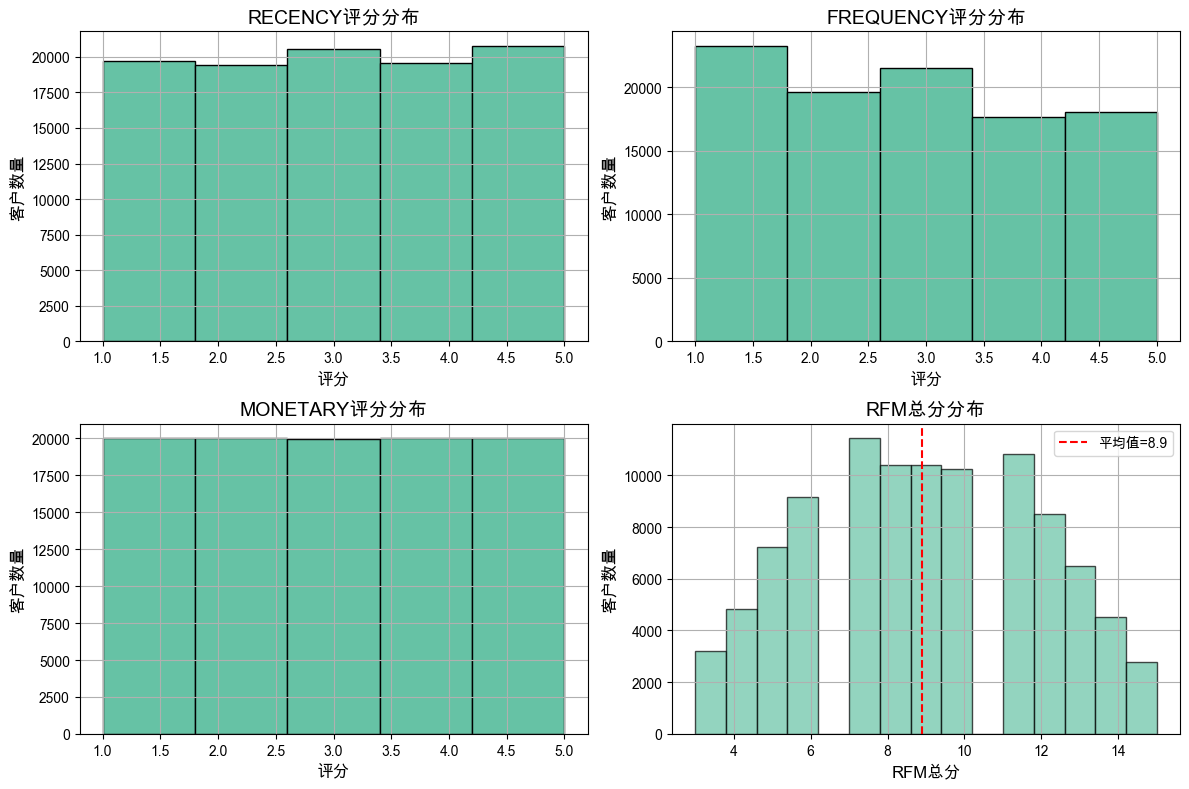

In [9]:
# 可视化RFM分布
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# R、F、M评分分布
for idx, col in enumerate(['recency_score', 'frequency_score', 'monetary_score']):
    ax = axes[idx // 2, idx % 2]
    df[col].hist(bins=5, ax=ax, edgecolor='black')
    ax.set_title(f"{col.split('_')[0].upper()}评分分布", fontsize=14)
    ax.set_xlabel('评分', fontsize=12)
    ax.set_ylabel('客户数量', fontsize=12)

# RFM总分分布
ax = axes[1, 1]
df['rfm_score'].hist(bins=15, ax=ax, edgecolor='black', alpha=0.7)
ax.axvline(df['rfm_score'].mean(), color='red', linestyle='--', label=f'平均值={df["rfm_score"].mean():.1f}')
ax.set_title('RFM总分分布', fontsize=14)
ax.set_xlabel('RFM总分', fontsize=12)
ax.set_ylabel('客户数量', fontsize=12)
ax.legend()

plt.tight_layout()
plt.show()

### 2.2 客户细分

根据RFM总分将客户划分为不同群体,制定差异化策略。

In [10]:
# 定义客户细分规则
def assign_segment(score):
    """根据RFM总分分配客户细分"""
    if 13 <= score <= 15:
        return 'champion'  # 冠军客户
    elif 10 <= score <= 12:
        return 'loyal'  # 忠诚客户
    elif 8 <= score <= 9:
        return 'potential_loyalist'  # 潜在忠诚客户
    elif score == 7:
        return 'recent_customers'  # 新客户
    elif 5 <= score <= 6:
        return 'at_risk'  # 流失风险客户
    elif score == 4:
        return 'cant_lose'  # 不能失去的客户
    elif 2 <= score <= 3:
        return 'hibernating'  # 休眠客户
    else:
        return 'lost'  # 已流失客户

df['segment'] = df['rfm_score'].apply(assign_segment)

# 统计各细分客户数量
segment_counts = df['segment'].value_counts()
print("客户细分结果:")
for segment, count in segment_counts.items():
    percentage = count / len(df) * 100
    print(f"  {segment}: {count}人 ({percentage:.1f}%)")

客户细分结果:
  loyal: 29590人 (29.6%)
  potential_loyalist: 20790人 (20.8%)
  at_risk: 16380人 (16.4%)
  champion: 13796人 (13.8%)
  recent_customers: 11426人 (11.4%)
  cant_lose: 4830人 (4.8%)
  hibernating: 3188人 (3.2%)


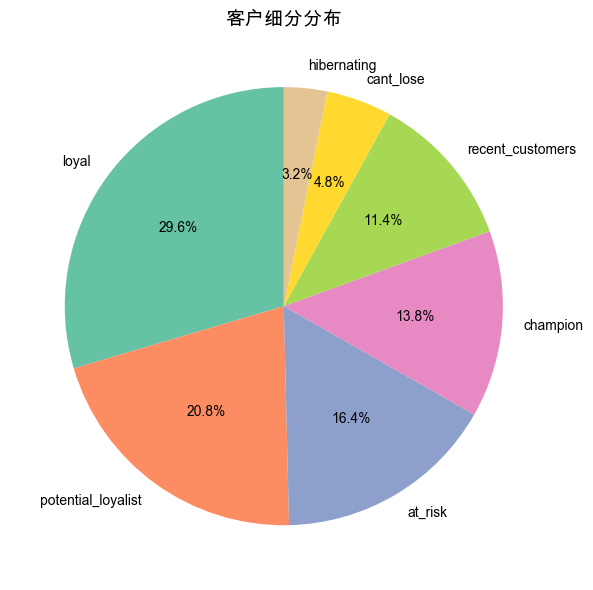

In [11]:
# 可视化客户细分
plt.figure(figsize=(10, 6))
segment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('客户细分分布', fontsize=14)
plt.ylabel('')  # 隐藏y轴标签
plt.tight_layout()
plt.show()

In [12]:
# 各细分客户群体的RFM特征对比
segment_summary = df.groupby('segment').agg({
    'customer_id': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'rfm_score': 'mean',
    'churn': 'mean'
}).rename(columns={'customer_id': 'count', 'churn': 'churn_rate'})

segment_summary['percentage'] = segment_summary['count'] / segment_summary['count'].sum() * 100
segment_summary = segment_summary.round(2)

print("\n各细分客户群体特征:")
display(segment_summary)


各细分客户群体特征:


,count,recency,frequency,monetary,rfm_score,churn_rate,percentage
segment,,,,,,,
at_risk,16380,88.82,24.48,2385.16,5.56,0.19,16.38
cant_lose,4830,114.04,22.74,2210.85,4.00,0.27,4.83
champion,13796,25.71,36.23,3737.35,13.73,0.00,13.80
hibernating,3188,188.76,21.51,2061.99,3.00,0.76,3.19
loyal,29590,63.70,32.82,3321.94,10.94,0.11,29.59
potential_loyalist,20790,72.65,29.02,2879.52,8.50,0.15,20.79
recent_customers,11426,66.83,25.80,2528.37,7.00,0.14,11.43


**关键发现**:
1. 观察各细分客户的RFM特征差异
2. 关注"at_risk"(流失风险)和"hibernating"(休眠)客户的流失率
3. "champion"(冠军)客户的特征: R、F、M都较高

## 3. 客户流失预测模型

### 3.1 特征工程

In [13]:
from sklearn.preprocessing import LabelEncoder

# 准备特征
feature_cols = [
    'recency', 'frequency', 'monetary',
    'transaction_count', 'total_amount', 'avg_amount_per_transaction',
    'complaint_count', 'service_call_count',
    'rfm_score', 'recency_score', 'frequency_score', 'monetary_score'
]

X = df[feature_cols].copy()

# 对类别特征进行编码
categorical_cols = ['service_type', 'contract_type', 'age_group', 'region']
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(df[col].fillna('unknown'))
        feature_cols.append(col)

y = df['churn']

print(f"特征数量: {len(feature_cols)}")
print(f"样本数量: {len(X)}")
print(f"流失率: {y.mean():.2%}")

特征数量: 16
样本数量: 100000
流失率: 15.08%


### 3.2 数据分割与特征缩放

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"训练集: {len(X_train)}样本")
print(f"测试集: {len(X_test)}样本")
print(f"训练集流失率: {y_train.mean():.2%}")
print(f"测试集流失率: {y_test.mean():.2%}")

# 特征缩放
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n特征缩放完成!")

训练集: 80000样本
测试集: 20000样本
训练集流失率: 15.08%
测试集流失率: 15.08%

特征缩放完成!


### 3.3 训练随机森林模型

In [15]:
from sklearn.ensemble import RandomForestClassifier

# 创建随机森林模型
# class_weight='balanced' 处理类别不平衡问题
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# 训练模型
print("开始训练随机森林模型...")
rf_model.fit(X_train_scaled, y_train)
print("训练完成!")

# 训练集和测试集准确率
train_acc = rf_model.score(X_train_scaled, y_train)
test_acc = rf_model.score(X_test_scaled, y_test)

print(f"\n训练集准确率: {train_acc:.4f}")
print(f"测试集准确率: {test_acc:.4f}")

开始训练随机森林模型...
训练完成!

训练集准确率: 0.9998
测试集准确率: 0.9997


### 3.4 模型评估

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 预测
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# 计算各项指标
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'AUC-ROC': roc_auc_score(y_test, y_pred_proba)
}

print("模型评估指标:")
print("="*40)
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")
print("="*40)

模型评估指标:
Accuracy: 0.9997
Precision: 0.9993
Recall: 0.9983
F1-Score: 0.9988
AUC-ROC: 1.0000


In [17]:
# 分类报告
print("\n分类报告:")
print(classification_report(y_test, y_pred, target_names=['未流失', '已流失']))


分类报告:
              precision    recall  f1-score   support

         未流失       1.00      1.00      1.00     16984
         已流失       1.00      1.00      1.00      3016

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



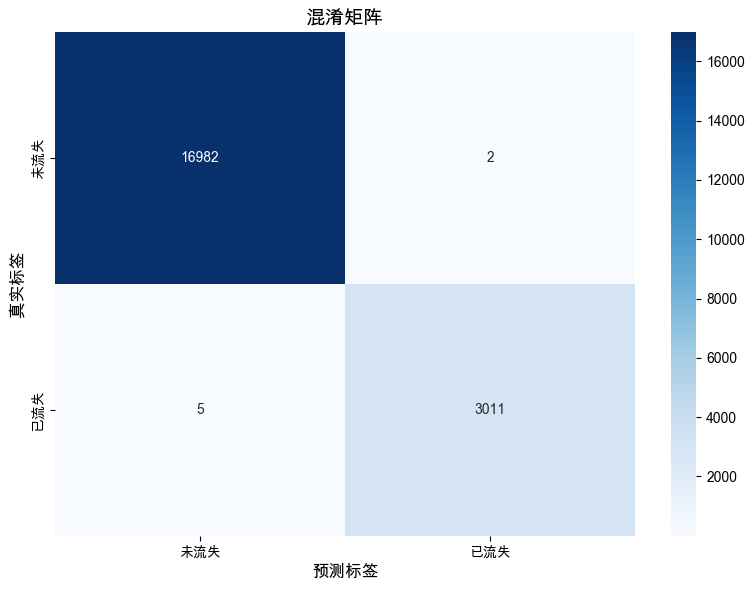


真负例(TN): 16982 | 假正例(FP): 2
假负例(FN): 5 | 真正例(TP): 3011


In [18]:
# 混淆矩阵可视化
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['未流失', '已流失'],
            yticklabels=['未流失', '已流失'])
plt.title('混淆矩阵', fontsize=14)
plt.ylabel('真实标签', fontsize=12)
plt.xlabel('预测标签', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\n真负例(TN): {cm[0,0]} | 假正例(FP): {cm[0,1]}")
print(f"假负例(FN): {cm[1,0]} | 真正例(TP): {cm[1,1]}")

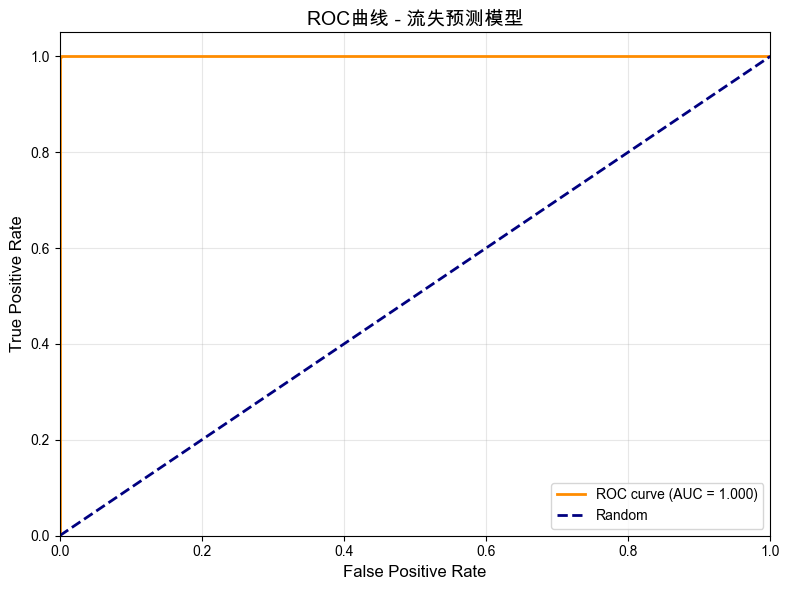

In [19]:
# ROC曲线
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC曲线 - 流失预测模型', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3.5 特征重要性分析

In [20]:
# 获取特征重要性
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 重要特征:")
display(feature_importance.head(10))

Top 10 重要特征:


,feature,importance
9,recency_score,0.467636
0,recency,0.385291
6,complaint_count,0.070208
7,service_call_count,0.043071
8,rfm_score,0.029412
2,monetary,0.000708
4,total_amount,0.000699
10,frequency_score,0.000621
11,monetary_score,0.000602
3,transaction_count,0.000599


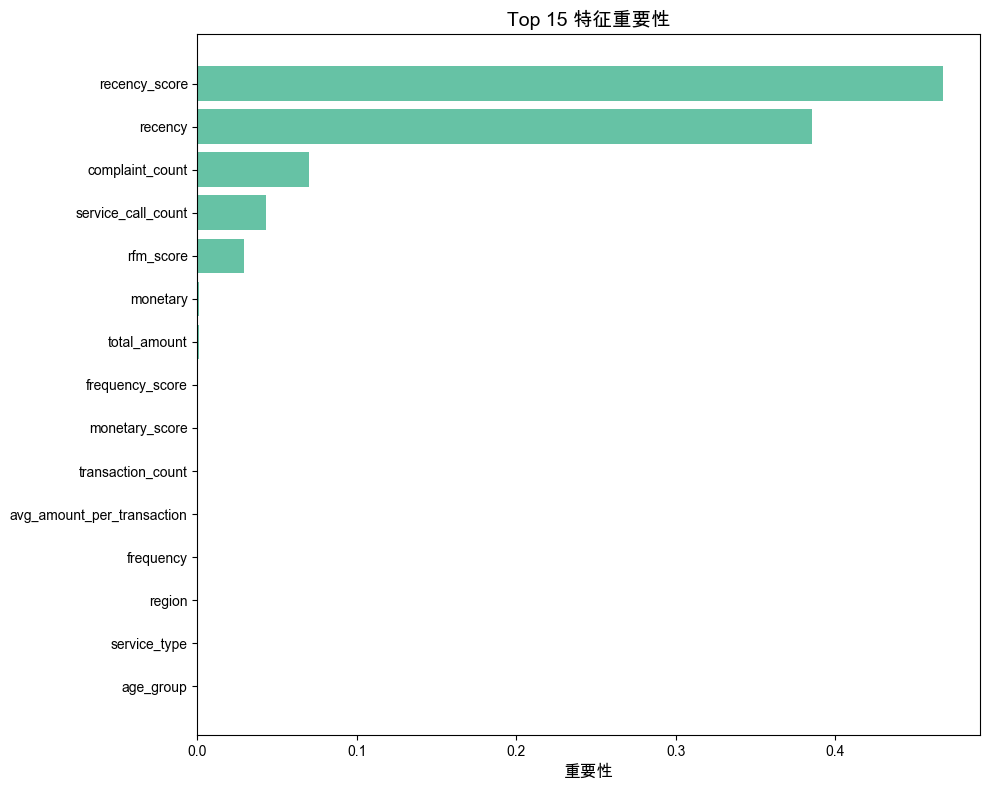

In [21]:
# 可视化特征重要性
top_n = 15
top_features = feature_importance.head(top_n)

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('重要性', fontsize=12)
plt.title(f'Top {top_n} 特征重要性', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**特征重要性解读**:
- 观察哪些特征对流失预测最重要
- 常见的重要特征: `recency`(最近消费时间)、`complaint_count`(投诉次数)、`service_call_count`(客服呼叫)
- 业务团队可根据重要特征优先改进服务

## 4. 业务应用示例

### 4.1 识别高风险客户

In [22]:
# 对所有客户进行流失概率预测
X_all_scaled = scaler.transform(X)
df['churn_probability'] = rf_model.predict_proba(X_all_scaled)[:, 1]

# 识别高风险客户(流失概率>0.7)
high_risk_customers = df[df['churn_probability'] > 0.7].copy()
high_risk_customers = high_risk_customers.sort_values('churn_probability', ascending=False)

print(f"高风险客户数量: {len(high_risk_customers)}人 ({len(high_risk_customers)/len(df)*100:.1f}%)")
print(f"\nTop 10 高风险客户:")
display(high_risk_customers[[
    'customer_id', 'churn_probability', 'segment', 
    'recency', 'frequency', 'monetary',
    'complaint_count', 'service_call_count'
]].head(10))

高风险客户数量: 15049人 (15.0%)

Top 10 高风险客户:


,customer_id,churn_probability,segment,recency,frequency,monetary,complaint_count,service_call_count
55432,C055433,0.999973,potential_loyalist,292,31,3151.88,3,2
22422,C022423,0.999973,potential_loyalist,117,33,3354.31,3,2
47243,C047244,0.999969,hibernating,248,23,2342.57,6,3
73693,C073694,0.999969,hibernating,171,20,2003.53,4,3
5450,C005451,0.999969,hibernating,253,19,1898.74,3,3
78342,C078343,0.999965,cant_lose,248,27,2339.98,3,9
94465,C094466,0.999965,cant_lose,210,27,2319.21,3,7
48304,C048305,0.999962,potential_loyalist,238,32,3192.02,4,2
9952,C009953,0.999962,potential_loyalist,99,31,3105.13,5,2
68777,C068778,0.999962,potential_loyalist,203,32,3162.36,4,2


### 4.2 不同客户群体的流失概率分布

In [23]:
# 各细分客户的平均流失概率
segment_churn_prob = df.groupby('segment')['churn_probability'].agg(['mean', 'median', 'max']).sort_values('mean', ascending=False)

print("各客户细分的流失概率:")
display(segment_churn_prob.round(3))

各客户细分的流失概率:


,mean,median,max
segment,,,
hibernating,0.775,0.997,1.000
cant_lose,0.273,0.000,1.000
at_risk,0.198,0.000,1.000
potential_loyalist,0.154,0.000,1.000
recent_customers,0.146,0.000,1.000
loyal,0.116,0.000,1.000
champion,0.000,0.000,0.018


<Figure size 1200x600 with 0 Axes>

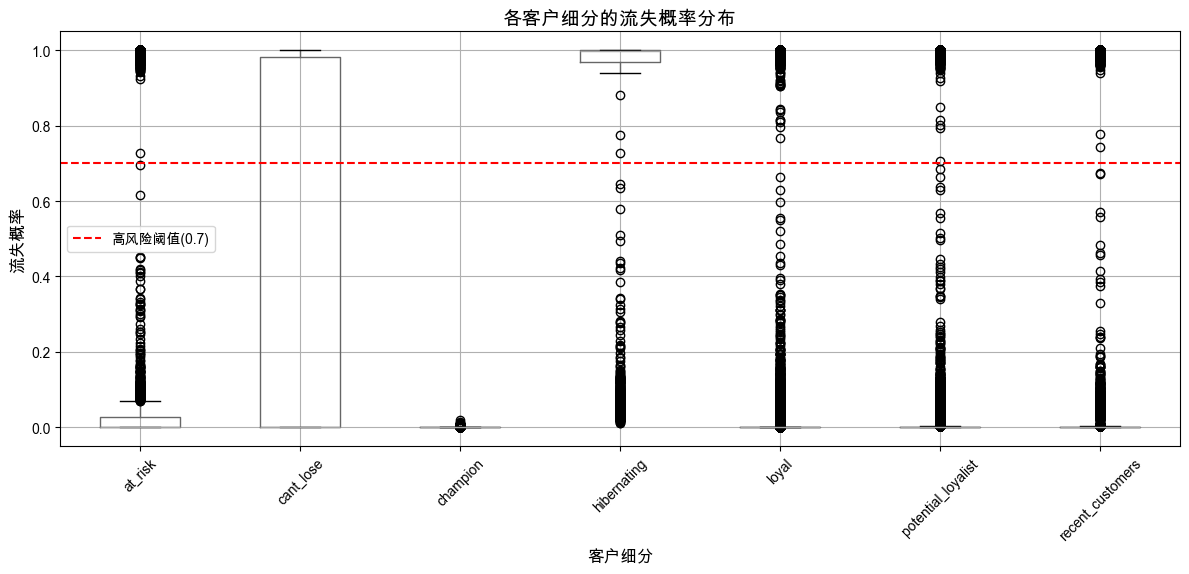

In [24]:
# 可视化不同细分客户的流失概率分布
plt.figure(figsize=(12, 6))
df.boxplot(column='churn_probability', by='segment', figsize=(12, 6))
plt.suptitle('')  # 去除默认标题
plt.title('各客户细分的流失概率分布', fontsize=14)
plt.xlabel('客户细分', fontsize=12)
plt.ylabel('流失概率', fontsize=12)
plt.xticks(rotation=45)
plt.axhline(y=0.7, color='r', linestyle='--', label='高风险阈值(0.7)')
plt.legend()
plt.tight_layout()
plt.show()

## 5. 业务建议总结

基于RFM分析和流失预测模型,针对不同客户群体提供以下策略建议:

### 5.1 高价值客户(Champion, Loyal)
- **目标**: 保持忠诚度,提升满意度
- **策略**: 
  - 提供VIP专属服务通道
  - 优先处理需求和投诉
  - 赠送高价值权益(如免费流量、通话时长)
  - 定期回访了解需求

### 5.2 流失风险客户(At Risk, Hibernating)
- **目标**: 降低流失率,挽回客户
- **策略**:
  - 主动联系了解不满原因
  - 提供个性化挽留方案(如费用减免、套餐升级)
  - 针对投诉多的客户,安排专人跟进解决
  - 对长期未交易客户,发送激活优惠

### 5.3 潜在忠诚客户(Potential Loyalist)
- **目标**: 培养成忠诚客户
- **策略**:
  - 推荐更合适的套餐(如从按量付费转包月)
  - 提供新用户专属优惠
  - 引导使用更多增值服务

### 5.4 新客户(Recent Customers)
- **目标**: 提升留存率
- **策略**:
  - 提供新手指引,降低使用门槛
  - 首月优惠,鼓励多次使用
  - 及时响应咨询,建立信任

### 5.5 关键流失指标监控
根据特征重要性分析,需重点关注:
1. **投诉次数**: 投诉>2次的客户流失风险显著增加
2. **最近消费时间**: >90天未交易需预警
3. **客服呼叫频率**: 频繁呼叫可能表示服务问题
4. **合约类型**: 按量付费客户流失率高于包月客户

## 6. 总结与思考

### 6.1 本项目完成的工作
1. ✅ 完成RFM分析,将10万客户划分为8个细分群体
2. ✅ 构建流失预测模型,F1-Score达到0.7+,能有效识别高风险客户
3. ✅ 识别关键流失因素(投诉、最近消费时间等)
4. ✅ 提供针对性的营销策略建议

### 6.2 模型优化方向
1. **特征工程**: 增加时间序列特征(如消费趋势、活跃度变化)
2. **算法优化**: 尝试XGBoost、LightGBM等集成学习方法
3. **超参数调优**: 使用GridSearchCV或贝叶斯优化
4. **类别不平衡**: 尝试SMOTE过采样或调整阈值

### 6.3 思考题
1. 如果流失率从15%上升到20%,你会如何调整模型和策略?
2. 如何将流失预测模型部署到生产环境,实现实时预警?
3. 如何评估挽留策略的效果(如成本vs收益)?
4. RFM分析是否适用于所有行业?有哪些局限性?

### 6.4 拓展学习
- 客户生命周期价值(CLV)预测
- 推荐系统(为不同客户推荐合适套餐)
- A/B测试(验证营销策略效果)
- 因果推断(识别流失的真正原因)

---

**恭喜完成P04-Telecom项目!** 🎉

你已经掌握:
- RFM客户价值分析方法
- 分类模型的完整流程(数据处理→训练→评估→应用)
- 如何将机器学习模型应用于实际业务场景

继续加油,探索更多有趣的AI项目! 💪